# Data Curation & Preprocessing  

### ✅ Tasks:  
- 📂 Load and filter dataset, then prepare each datapoint  
- 📊 Explore, visualize, balance price distribution  
- 💾 Export `.pkl`, upload to HF Hub  

In [ ]:
# imports

import os
import random
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np
import pickle

In [ ]:
!pip install datasets==2.19.2

In [ ]:
## login to hugging face
from google.colab import userdata
hf_token=userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

# 📥 Data Loading & Curation (Simultaneously)

We load and curate the data at the same time using **`loaders.py`** and **`items.py`**.

### 📂 Datasets
- Sourced from **Hugging Face**

### ⚙️ loaders.py
- Handles **parallel loading** and **filtering** of products  

### 📝 items.py
-  Defines the **`Item` class** to:
  -  Clean data  
  - Validate fields  
  - prepare each datapoint (**title, description, price...**) for modeling  

In [ ]:
dataset_names = [
    "Automotive",
    "Electronics",
    "Office_Products",
    "Tools_and_Home_Improvement",
    "Cell_Phones_and_Accessories",
    "Appliances",
    "Musical_Instruments",
]

In [ ]:
## import loaders and items
from loaders import ItemLoader
from items import Item

In [ ]:
items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load())

In [ ]:
print(f"A grand total of {len(items):,} items")

In [ ]:
# Investigate the first item from the list

datapoint = items[0]

# Access various attributes
title = datapoint.title
details = datapoint.details
price = datapoint.price
category = datapoint.category

print(f"Datapoint: {datapoint}")
print(f"Title: {title}")
print(f"Detail: {details}")
print(f"Price: ${price}")
print(f"Category: {category}")

In [ ]:
# The prompt that will be used during training
print(items[0].prompt)
# The prompt that will be used during testing
print(items[0].test_prompt())

## 📊 Data Visualization

In [ ]:
plt.figure(figsize=(15, 6))

In [ ]:
# Plot the distribution of token counts

tokens = [item.token_count for item in items]
avg_tokens = f"{sum(tokens) / len(tokens):,.1f}"
plt.title(f"Token counts: Avg {avg_tokens} and highest {max(tokens):,}\n")
plt.xlabel("Length (tokens)")
plt.ylabel("Count")
plt.hist(tokens, rwidth=0.7, color="blue", bins=range(0, 300, 10))
plt.show()

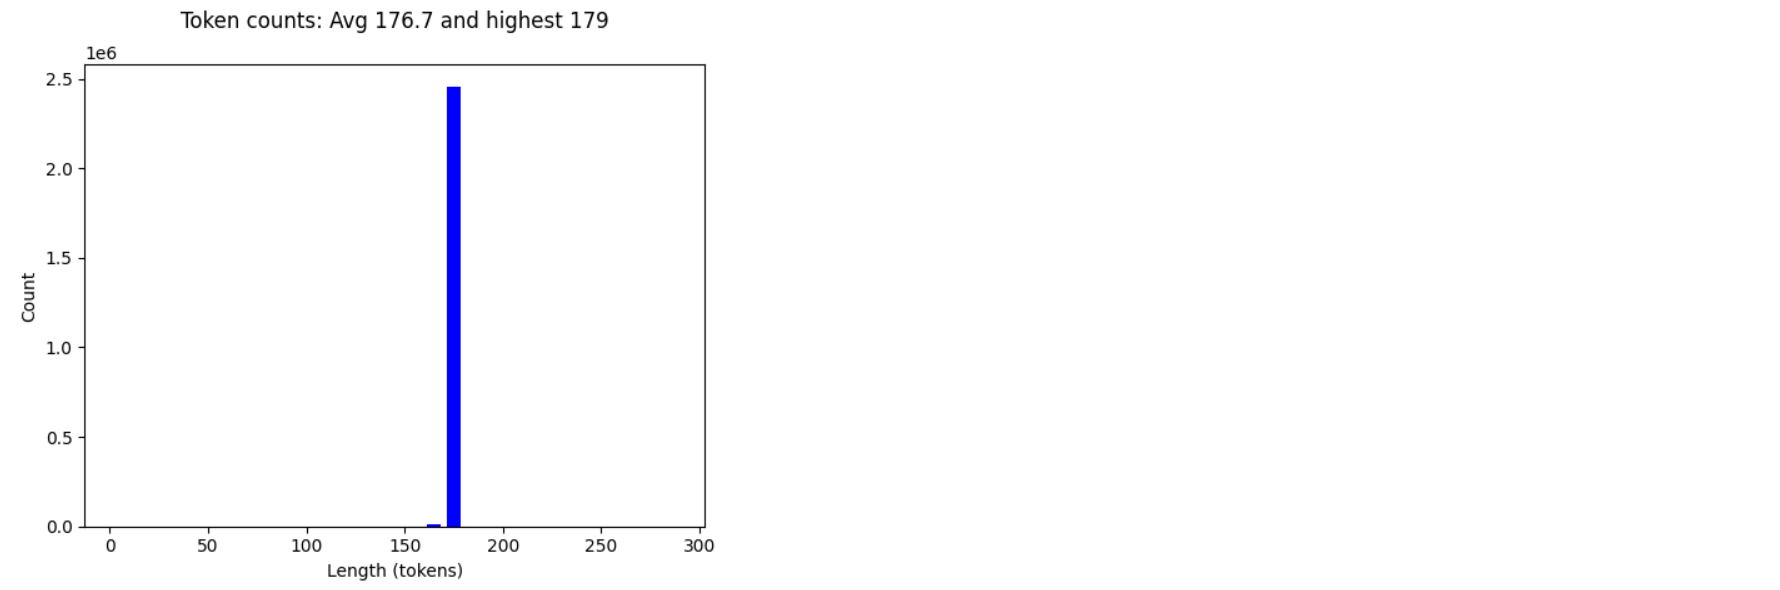

In [ ]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.title(f"Prices: Avg {sum(prices) / len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel("Price ($)")
plt.ylabel("Count")
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

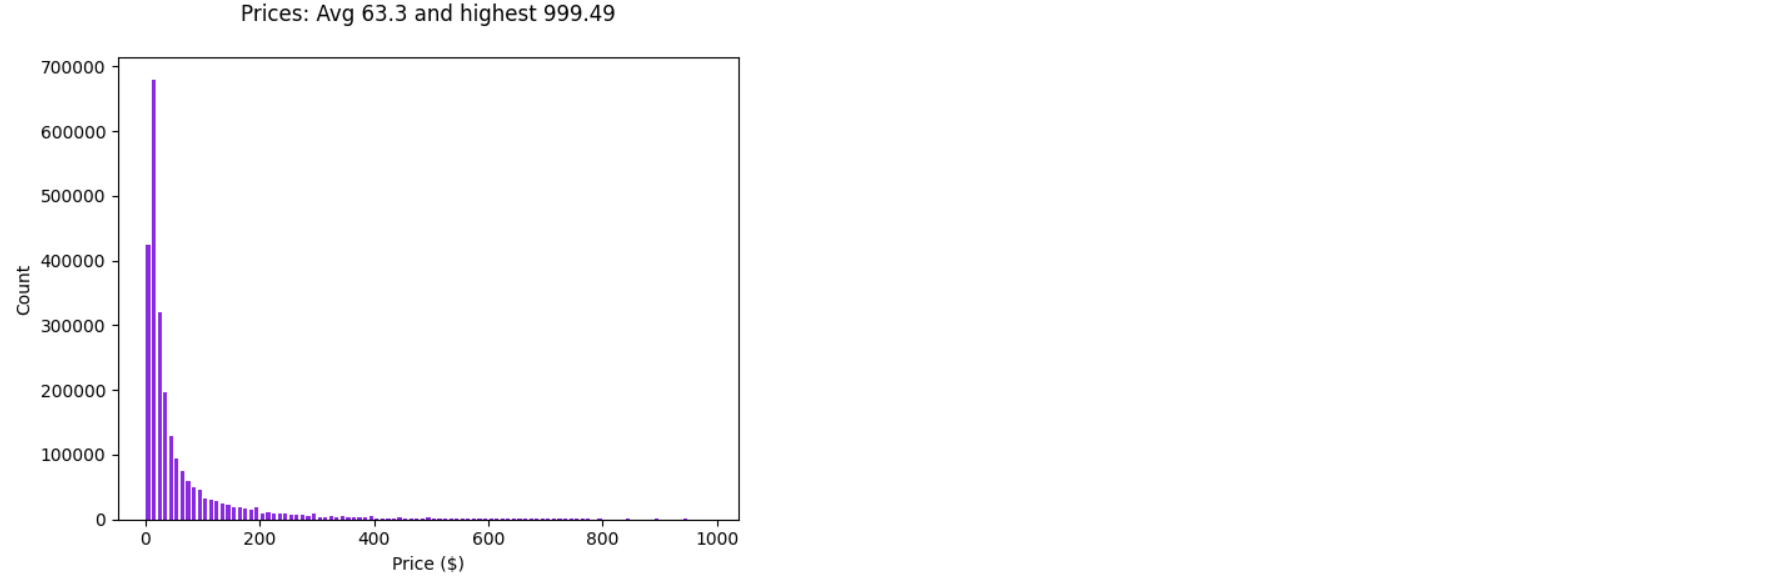

In [ ]:
# Plot the distribution of categories

category_counts = Counter()
for item in items:
    category_counts[item.category] += 1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Bar chart by category
plt.bar(categories, counts, color="goldenrod")
plt.title("How many items in each category")
plt.xlabel("Categories")
plt.ylabel("Count")

plt.xticks(rotation=30, ha="right")

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha="center", va="bottom")

# Display the chart
plt.show()

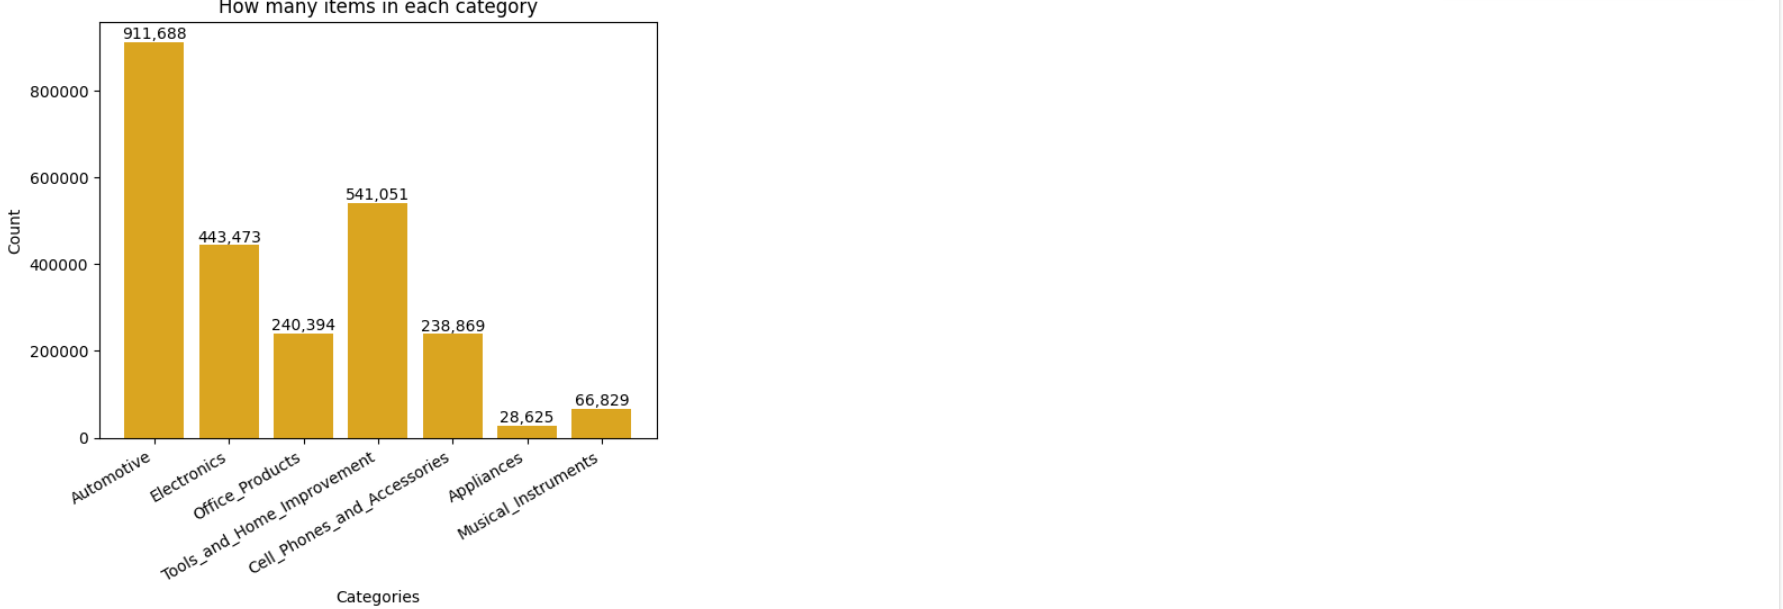

# 📦 Data Sampling  

We sample to keep the dataset **balanced but rich**:  

### 🎯 Strategy  
- ✅ Keep **all items** if `price ≥ $240` or `group size ≤ 1200`  
-  For large groups, **randomly sample 1200 items**, favoring rare categories  

###  Outcome  
- 💎 Preserves **valuable high-price items**  
- 🚫 Avoids **overrepresented classes**

In [ ]:
HEAVY_DATASET = "Automative"

# Group items by rounded price
# Slots is a dictionary where the keys are rounded prices
# and the values are lists of items that have that rounded price
slots = defaultdict(list)
for item in items:
    slots[round(item.price)].append(item)

np.random.seed(42)  # Set random seed for reproducibility
sample = []  # Final collection of items after our sampling process completes

# Sampling loop
for price, items_at_price in slots.items():
    # Take all items if price ≥ 240 or small group
    if price >= 240 or len(items_at_price) <= 1200:
        sample.extend(items_at_price)

    # Otherwise sample 1200 items with weights
    else:
        # Weight: 1 for toys, 5 for others
        weights = [
            1 if item.category == HEAVY_DATASET else 5 for item in items_at_price
        ]
        weights = np.array(weights) / sum(weights)

        indices = np.random.choice(
            len(items_at_price),
            1200,
            replace=False,  # don't pick the same index twice
            p=weights,
        )
        sample.extend([items_at_price[i] for i in indices])

print(f"There are {len(sample):,} items in the sample")

In [ ]:
# Plot the distribution of prices in the sample

prices = [float(item.price) for item in sample]
plt.title(f"Avg {sum(prices) / len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel("Price ($)")
plt.ylabel("Count")
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

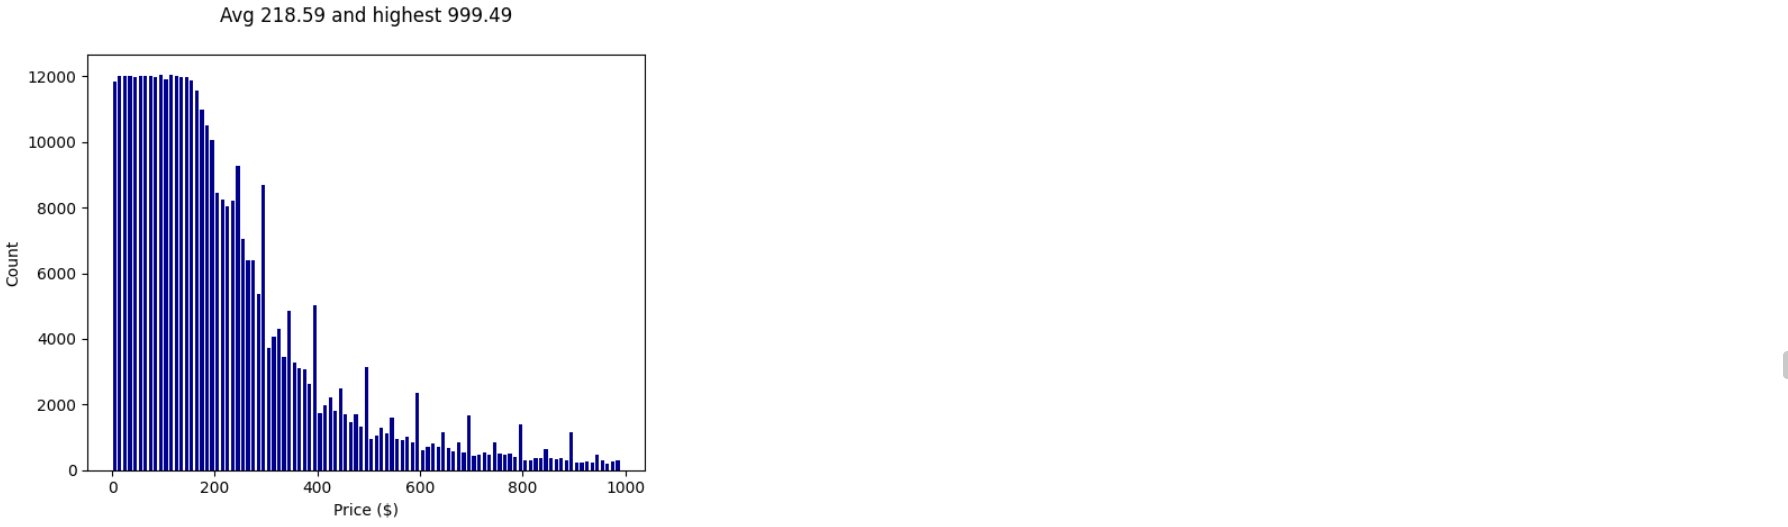

In [ ]:
# Plot the distribution of categories in the sample

category_counts = Counter()
for item in sample:
    category_counts[item.category] += 1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Create bar chart
plt.bar(categories, counts, color="pink")

# Customize the chart
plt.title("How many in each category")
plt.xlabel("Categories")
plt.ylabel("Count")

plt.xticks(rotation=30, ha="right")

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha="center", va="bottom")

# Display the chart
plt.show()

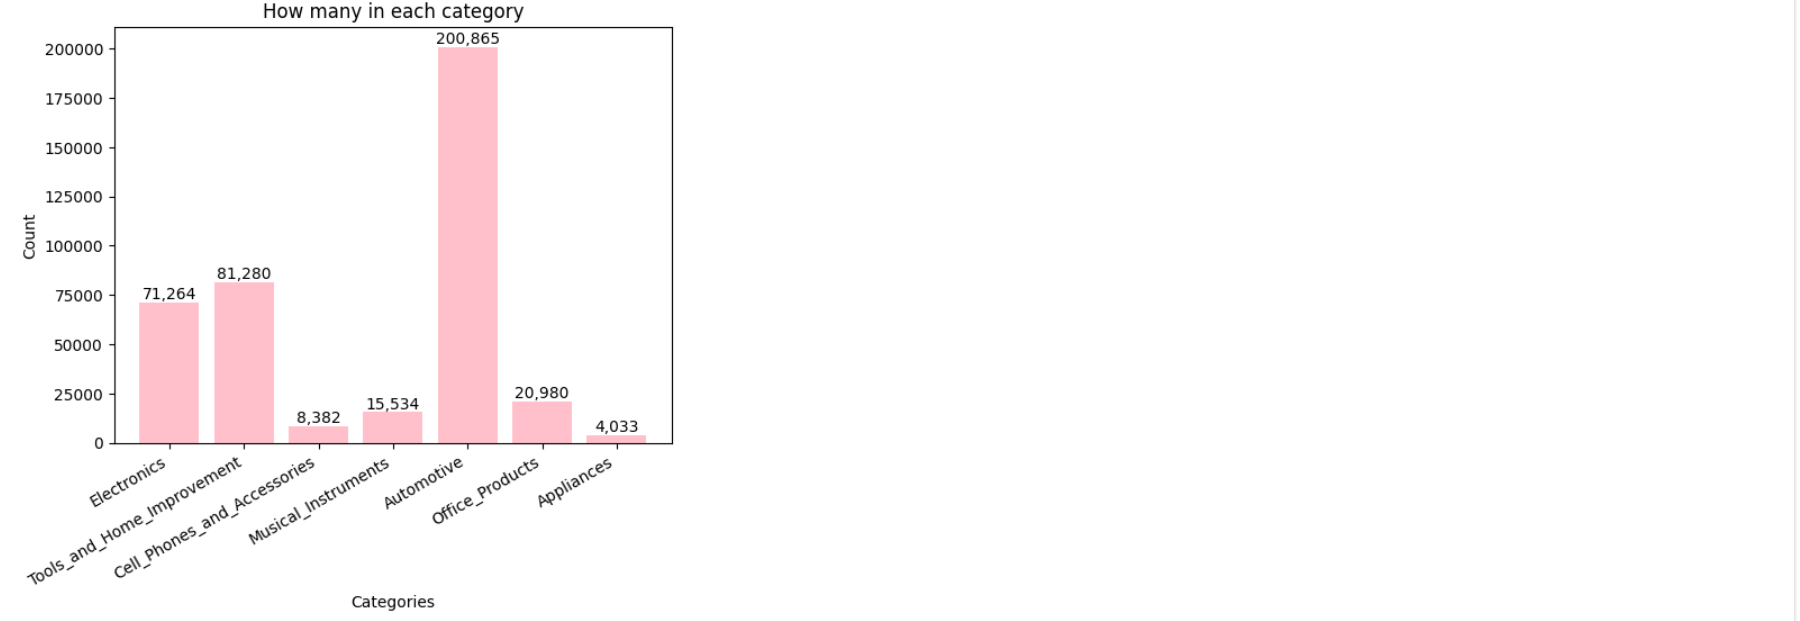

In [ ]:
# How does the price vary with the character count of the prompt?

sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.scatter(sizes, prices, s=0.2, color="red")

# Add labels and title
plt.xlabel("Size")
plt.ylabel("Price")
plt.title("Is there a simple correlation between prompt length and item price?")

# Display the plot
plt.show()

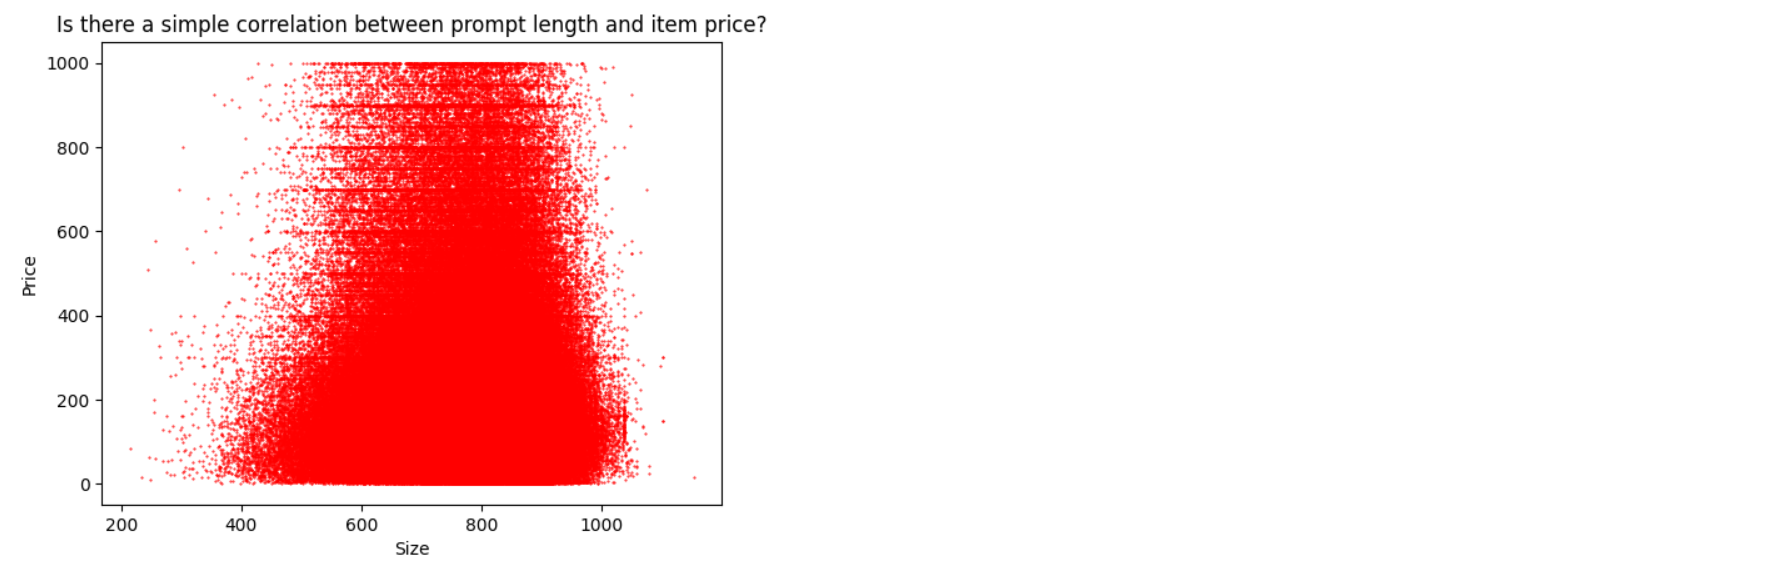

## ✅ Final Check Before Training

In [ ]:
def report(item):
    prompt = item.prompt
    tokens = Item.tokenizer.encode(item.prompt)
    print(prompt)
    print(tokens[-10:])
    print(Item.tokenizer.batch_decode(tokens[-10:]))

In [ ]:
report(sample[50])

## 📦 Creating Train/Test Datasets

In [ ]:
random.seed(42)
random.shuffle(sample)
train = sample[:400_000]
test = sample[400_000:402_000]
print(
    f"Divided into a training set of {len(train):,} items "
    f"and test set of {len(test):,} items"
)

In [ ]:
#  Extract prompts and prices
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

# Create Hugging Face datasets
train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({"train": train_dataset, "test": test_dataset})

# Push to the Hugging Face Hub
USERNAME = "srajal87"  # 🔧 Replace with your Hugging Face username
DATASET_NAME = f"{USERNAME}/pricer-data"

dataset.push_to_hub(DATASET_NAME, private=True)